<a href="https://colab.research.google.com/github/alfanugraha/mlzoomcamp-homework/blob/master/04_evaluation_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_auc_score, auc
from sklearn.model_selection import KFold

## Data Preparation

We will use the lead scoring Bank Marketing dataset https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numeric_columns = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [ ]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

There are 5 columns with missing values:
- `lead_source` as object
- `industry` as object
- `annual_income` as numeric
- `employment_status` as object
- `location` as object

For categorical features, I replace them with `NA`, and for numerical features I replace it with with `0.0`

In [ ]:
for col in categorical_columns:
    df[col] = df[col].fillna("NA")

for col in numeric_columns:
    df[col] = df[col].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [ ]:
y = df['converted']
X = df.drop('converted', axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"Train: {len(X_train)} ({len(X_train)/len(df)*100:.0f}%)")
print(f"Val: {len(X_val)} ({len(X_val)/len(df)*100:.0f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(df)*100:.0f}%)")

Train: 877 (60%)
Val: 292 (20%)
Test: 293 (20%)


## Q1. ROC AUC feature importance

In [ ]:
variables_to_test = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for var in variables_to_test:
    predictions = X_train[var]
    auc = roc_auc_score(y_train, predictions)

    if auc < 0.5:
        predictions = -X_train[var]
        auc = roc_auc_score(y_train, predictions)

    auc_scores[var] = auc
    print(f"{var}: {auc:.4f}")

best_var = max(auc_scores, key=auc_scores.get)
print(f"Highest AUC: {best_var} ({auc_scores[best_var]:.4f})")

lead_score: 0.6111
number_of_courses_viewed: 0.7652
interaction_count: 0.7272
annual_income: 0.5446
Highest AUC: number_of_courses_viewed (0.7652)


## Q2. Training the model

In [ ]:
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

auc = roc_auc_score(y_val, y_val_pred >= 0.5)
print(f"AUC on validation dataset: {round(auc, 3)}")

AUC on validation dataset: 0.691


## Q3. Precision and Recall

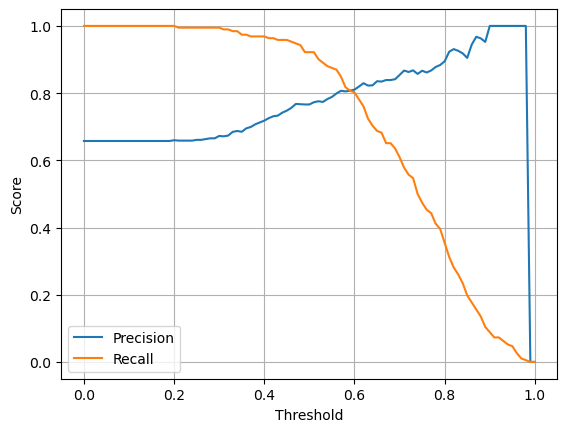

In [ ]:
scores = []

thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred >= t)
    predict_negative = (y_val_pred < t)

    TP = (predict_positive & actual_positive).sum()
    TN = (predict_negative & actual_negative).sum()

    FP = (predict_positive & actual_negative).sum()
    FN = (predict_negative & actual_positive).sum()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0.0

    if TP + FN > 0:
        recall = TP / (TP + FN)
    else:
        recall = 0.0

    scores.append([t, precision, recall])

df_scores = pd.DataFrame(data=scores, columns=["threshold", "precision", "recall"])

plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()

In [ ]:
precisions = df_scores.precision
recalls = df_scores.recall

differences = np.abs(precisions - recalls)
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]

print(f"Precision and recall intersect at threshold: {intersection_threshold:.3f}")
print(f"Precision: {precisions[intersection_idx]:.3f}")
print(f"Recall: {recalls[intersection_idx]:.3f}")

Precision and recall intersect at threshold: 0.590
Precision: 0.807
Recall: 0.807


## Q4. F1 score

    threshold  precision    recall        f1
47       0.47   0.767932  0.947917  0.848485


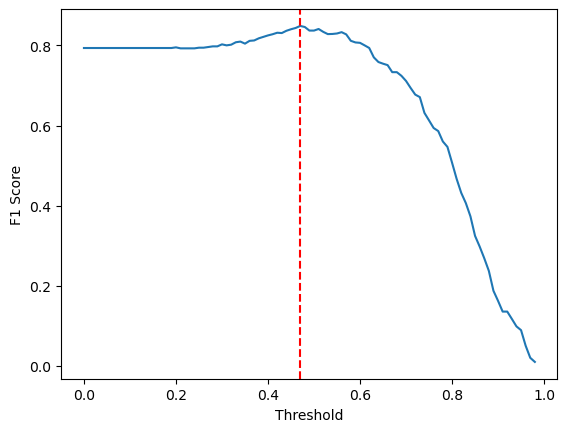

In [ ]:
df_scores["f1"] = 2*(df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
max_score_row = df_scores[df_scores.f1 == df_scores.f1.max()]
print(max_score_row)

plt.plot(df_scores.threshold, df_scores.f1, label='F1')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.axvline(x=float(max_score_row.iloc[0].threshold), color='r', linestyle='--')

## Q5. 5-Fold cross-validation

In [ ]:
X_train_full = np.concatenate([X_train_encoded, X_val_encoded], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_full), 1):
    X_fold_train = X_train_full[train_idx]
    X_fold_val = X_train_full[val_idx]

    y_fold_train = y_train_full[train_idx]
    y_fold_val = y_train_full[val_idx]

    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train, y_fold_train)

    y_fold_pred = model_fold.predict_proba(X_fold_val)[:, 1]
    auc_fold = roc_auc_score(y_fold_val, y_fold_pred)
    auc_scores.append(auc_fold)

    print(f"Fold {fold}: AUC = {auc_fold:.4f}")

# Calculate statistics
auc_scores = np.array(auc_scores)
mean_auc = auc_scores.mean()
std_auc = auc_scores.std()

print(f"Mean AUC: {mean_auc:.4f} +- {std_auc:.4f}")

X_train_full shape: (1169, 31)
y_train_full shape: (1169,)
Fold 1: AUC = 0.8067
Fold 2: AUC = 0.8068
Fold 3: AUC = 0.8648
Fold 4: AUC = 0.8334
Fold 5: AUC = 0.8154
Mean AUC: 0.8254 +- 0.0220


## Q6. Hyperparameter tuning

In [ ]:
C_values = [0.000001, 0.001, 1]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in C_values:
    print(f"Testing C = {C}")
    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_full), 1):
        X_fold_train = X_train_full[train_idx]
        X_fold_val = X_train_full[val_idx]

        y_fold_train = y_train_full[train_idx]
        y_fold_val = y_train_full[val_idx]

        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_fold_train, y_fold_train)

        y_fold_pred = model_fold.predict_proba(X_fold_val)[:, 1]
        auc_fold = roc_auc_score(y_fold_val, y_fold_pred)
        auc_scores.append(auc_fold)

    auc_scores = np.array(auc_scores)
    mean_auc = round(auc_scores.mean(), 3)
    std_auc = round(auc_scores.std(), 3)

    results[C] = {'mean': mean_auc, 'std': std_auc}
    print(f"C = {C}: mean AUC = {mean_auc}, std = {std_auc}")

for C in C_values:
    print(f"C = {C:>8}: mean = {results[C]['mean']:.3f}, std = {results[C]['std']:.3f}")

best_mean = max(r['mean'] for r in results.values())
candidates = [C for C in C_values if results[C]['mean'] == best_mean]
best_C = min(candidates)

print(f"Best C: {best_C} (mean = {results[best_C]['mean']:.3f}, std = {results[best_C]['std']:.3f})")

Testing C = 1e-06
C = 1e-06: mean AUC = 0.543, std = 0.025
Testing C = 0.001
C = 0.001: mean AUC = 0.864, std = 0.014
Testing C = 1
C = 1: mean AUC = 0.825, std = 0.022
C =    1e-06: mean = 0.543, std = 0.025
C =    0.001: mean = 0.864, std = 0.014
C =        1: mean = 0.825, std = 0.022
Best C: 0.001 (mean = 0.864, std = 0.014)
